In [31]:
##Felipe Ixcamparic, 2021- Proyecto de prácticas/Tésis 2021 | USAC-UNAM

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import numpy as np

# Import Qiskit classes
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

#LIBRERÍAS PARA TODO LO NECESARIO: 
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Importación de qiskit
from qiskit import *

%matplotlib inline
from matplotlib import *

#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble
import numpy as np 
from numpy import *

# Librerías estandar de qiskit
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info import *
from qiskit.extensions import Initialize
# import import_ipynb

#Funciones creadas para generar estados aleatorios
# from qubit_aleatorio import estado_aleatorio_normal
# import qubit_aleatorio as al

#Para dibujar sobre la esfera de bloch
from kaleidoscope import bloch_sphere
#Extración
import scipy
import re 
import collections as colect
import matplotlib.pyplot as plt

/tmp/ipykernel_150/249222572.py:16: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


# Creación de estados mixtos en computadoras cuánticas: 

El siguiente notebook se enfoca en crear estados mixtos en computadoras cuánticas, ya que no es posible inicializar un ensamble estadístico deseado, es necesario buscar otro tipo de métodos. El siguiente método toma su estructura del paper: https://arxiv.org/pdf/2001.02552.pdf. Como también unos conceptos del paper:  https://arxiv.org/pdf/1905.10876.pdf. 

## Ansatz:
Es un circuito parametrizado por una rotación unitaria U(θ), usada para preparar un estado deseado de la forma $|Ψ(θ)⟩=U(θ)|e_0>$. 

Buscamos realizar esta parametrización en el siguiente circuito, consistiendo de n_qubits para el sistema y n_qubits para el entorno, trazando parcialmente el entorno para obtener la matriz densidad del sistema. 

Buscamos entonces $ρ(θ)$, donde $\vec{ θ}$ es un vector de rotaciones implementadas en cada compuerta del Ansatz.


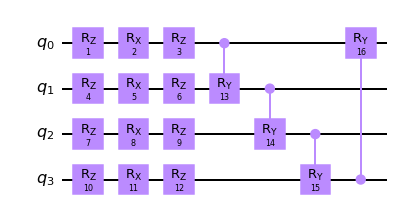

In [2]:
#Inicializacion de un estado mixto en una CC: 

#Creando el Ansatz:
def cirq_ansq(qubits,parameters,layers):
    '''
    Generador de ansatz para un sistema cerrado (sistema-entorno). 
    
    Entradas:
    --------------
        qubits:int
            número de qubits correspondiente a la dimension de la matriz densidad a generar.
        parameters: float-array
            vector de parámetros theta, correspondiente a las rotaciones a realizar en el circuito. 
            **Se necesitan 8*qubits*capas parámetros. 
        layers: int 
            número de capas a utilizar en el circuito para generar la matriz densidad. 
    
    Salidas: 
    ------------
        ansq: Objeto tipo quantum circuit
            Circuito cuántico generado
        rho_sist: Objet tipo DensityMatrix
            Matriz densidad del sistema, tras trazar parcialmente el entorno. 
    
    '''
    #Se genera un circutio de 2n qubits (la mitad para la matriz densidad, la otra para los qubits de entorno). 
    ansq=QuantumCircuit(2*qubits)
    
    #Se aplican por capas las rotaciones correspondientes indicadas en el paper de referencia. 
    for j in range(layers):
        for i in range(2*qubits): 
#             ansq.rx(parameters[0],i)
#             parameters= np.delete(parameters,0)
#             ansq.rz(parameters[0],i)
#             parameters= np.delete(parameters,0)
            
            
            ansq.rz(parameters[0],i)
            parameters= np.delete(parameters,0)
            ansq.rx(parameters[0],i)
            parameters= np.delete(parameters,0)
            ansq.rz(parameters[0],i)
            parameters= np.delete(parameters,0)
    
    #Se completa con compuertas cry para dar intereacción entre los qubits. 
    for w in range(2*qubits-1):

        
        ansq.cry(parameters[0],w,w+1)
        parameters= np.delete(parameters,0)     
        if w==(2*qubits-2):
            ansq.cry(parameters[0],w+1,0)
            parameters= np.delete(parameters,0)
        
        '''
        Descomentar abajo y comentar el bloque de arriba
        para usar CB anzats (ref: https://arxiv.org/pdf/1905.10876.pdf).
        '''
    
        # ansq.crx(parameters[0],w,w+1)
        # parameters= np.delete(parameters,0)     
        # if w==(2*qubits-2):
        #     ansq.crx(parameters[0],w+1,0)
        #     parameters= np.delete(parameters,0)
    

    
    #Se guarda en un vector los qubits de entorno a ser trazados. 
    ancilla=[]
    for k in range(qubits,2*qubits):
        ancilla.append(k)
    
    rho_sist=qi.partial_trace(qi.DensityMatrix(ansq),ancilla)
    
    return ansq, rho_sist

#La función puede ser probada claro, se necesitan
circ= cirq_ansq(qubits=2,parameters=np.linspace(1,35,35),layers=1)
circ[0].draw()

## Función de Costo: 
Una función de costo suele ser asociada a un valor con cada posible solución a un problema en orden de elegir el más óptimo, en la mayoría de casos se busca minimizar esta función.    (ref: https://docs.microsoft.com/en-us/azure/quantum/optimization-concepts-cost-functions) 

Nuestro objetivo es hallar una función de costo que optimice nuestros parámetros theta de tal forma que correspondan a la matriz densidad que buscamos.
Para ello definimos nuestra función de costo como la fidelidad entre el estado objetivo y la matriz densidad obtenida del circuito anterior. 

$C(\theta) = Fidelidad(\rho(\theta),\rho_{target})$

In [3]:
target=[[1/2,0],[0,1/2]]  #Matriz densidad objetivo
cost_por_iteracion=[]    #Almacenamiento la fidelidad en cada iteracion

def cost_func(params):
    '''
    Función de costo para hallar la matriz densidad objetivo. 
    
    Entradas:
        Globales: 
            qubits: int
                número de qubits a usar en el circuito. 
            layers: int
                número de capas a usar en el circuito. 
            target: array, float
                matriz densidad objetivo 
        Locales: 
            params:float,array
                parametros theta, correspondientes a las rotaciones a usar. 
    
    '''
    Dens= cirq_ansq(qubits,params,1)[1]
    cost=-qi.state_fidelity(Dens,target)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
    cost_por_iteracion.append(cost)
    return cost

Esta función de costo entonces busca ser optimizada para encontrar el vector $\vec{\theta}$ correspondiente a la Fidelidad máxima entre $\rho(\theta)$ y $\rho_{target}$. Para ello se usa el optimizador de scipy, con el método de COBYLLA. 

In [4]:
'''Proceso de minimización:
     Para este proceso se declaran condiciones iniciales, se minimizan los parámetros theta
     y se encuentran los valores óptimos que coindican con nuestra matriz densidad objetivo. 
'''
#Condiciones iniciales movibles:

qubits=1 #Se designa el número de qubits
capas=1  #Se establece el número de capas
target=qi.Pauli('I').to_matrix()/2 #Matriz densidad objetivo
cost_por_iteracion=[] #Se resetea el vector de iteraciones
maxitr=40  #Número máximo de iteraciones

#Se eligen valores iniciales de 0 a 2-pi ya que es el ángulo máximo posible de rotación. 
parame2=np.random.rand(8*qubits,1)*2*np.pi

results = scipy.optimize.minimize(cost_func,parame2,method='COBYLA',options={'maxiter':maxitr}) 

In [15]:
results

     fun: -0.9999884094370858
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 40
  status: 2
 success: False
       x: array([[2.62575634],
       [2.29452043],
       [2.46847741],
       [3.35078611],
       [4.3207239 ],
       [6.23712793],
       [1.89034862],
       [3.50679681]])

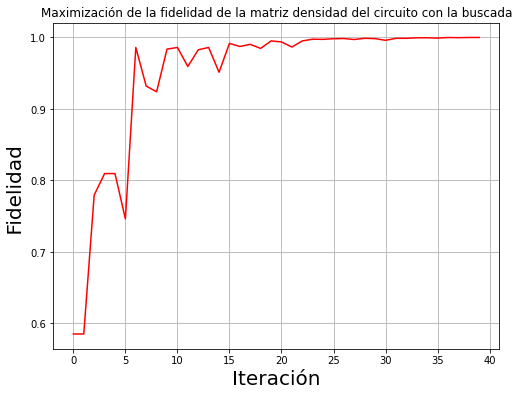

In [29]:
fidel_vals=[]
for i in range(len(cost_por_iteracion)):
    fidel_vals.append(cost_por_iteracion[i]*-1)
fig=plt.figure(figsize=(8, 6))
plt.plot(fidel_vals,'r-')
plt.xlabel("Iteración",size=20)
plt.ylabel(" Fidelidad  ",size=20)
plt.title("Maximización de la fidelidad de la matriz densidad del circuito con la buscada")
plt.grid() 
plt.savefig('iteraciones.png')
fig.show()    

In [6]:
cirq_ansq(1,results.x,1)[1].draw('latex')

<IPython.core.display.Latex object>

## Uso del circuito en una computadora cuántica: 


Teniendo los parámetros óptimos mediante simulación, entonces ya es posible usarlos en una computadora cuántica, iniciaremos comprobando su fidelidad mediante tomografía de estado

In [7]:
def state_tomo(n_shots,circuito,qubits,server=None):
    '''
    Función para ejecutar tomografía de estado cuántico sobre un circuito cuántico 
    
    Entradas: 
        n_shots: int
            número de tiros para las corridas. 
        circuito: QuantumCircuit
            Circuito cuántico para realizar el proceso de tomografía
        qubits: int
            Número de qubits para realizarle el proceso de tomografía
        server: int
            0 --> Se ejecuta en el simulador
            1---> Se ejecuta en una computadora cuántica.
            Por defecto estará en 0 si no se llena el campo , siendo en un simulador. 
    
    Salidas:
        rho_fit: Objeto DensityMatrix.
            Matriz densidad obtenida tras el proceso de tomografía de estado. 
    '''
    
    #Se guarda en un vector los qubits a trazar. 
    obtain=[]
    for i in range(qubits):
        obtain.append(i)
     
    #Creación de circuitos de tomografía y respectiva ejecución. 
    qst_q0 = state_tomography_circuits(circuito, obtain) 
    
    if server==None or server==0:
        job = qiskit.execute(qst_q0,Aer.get_backend('qasm_simulator'), shots=n_shots)
        job_monitor(job)
        resultado = StateTomographyFitter(job.result(), qst_q0)
        #Obtención de la matriz densidad luego de la tomografía de estado. 
        rho_fit = resultado.fit(method='lstsq')
        rho_fit = qi.DensityMatrix(rho_fit)
        return rho_fit  

    
    elif server==1: 
        job = qiskit.execute(qst_q0,backend=qcomp , shots=n_shots)
        job_monitor(job)
        resultado = StateTomographyFitter(job.result(), qst_q0)
        #Obtención de la matriz densidad luego de la tomografía de estado. 
        rho_fit1 = resultado.fit(method='lstsq')
        rho_fit1 = qi.DensityMatrix(rho_fit1)
        return rho_fit1
    
    else:
        print('Este no es un número válido')

In [8]:
#Se ejecuta el circuito con los parámetros optimizados y se le hace tomografía de estado 
rho_simulation= state_tomo(n_shots= 5000,circuito=cirq_ansq(1,results.x,1)[0] ,qubits=1,server=0)

Job Status: job has successfully run


In [9]:
#Es posible realizar lo mismo en alguna computadora cuántica. 
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') 

rho_qcomp= state_tomo(3000,cirq_ansq(1,results.x,1)[0],1,1) 

Job Status: job has successfully run


In [10]:
Fidelidad_simu = qi.state_fidelity(target,rho_simulation)
Fidelidad_qcomp = qi.state_fidelity(target,rho_qcomp)

print('Matriz densidad objetivo' + str(target))
print('Fidelidad con simulación: '+str(Fidelidad_simu))
print('Fidelidad con q_comp: '  + str(Fidelidad_qcomp)) 

Matriz densidad objetivo[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Fidelidad con simulación: 0.9998170065133842
Fidelidad con q_comp: 0.9992498817670817
